# 베이스라인 코드 해설

## Fixed Random Seed
seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [1]:
import numpy as np
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## 데이터 불러오기 및 확인
train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [2]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0


## EDA : 범주형 변수 확인하기
데이터에서 확인할 수 있는 범주형 변수들이 어떤 값들로 구성되어 있는지 확인해 봅시다  

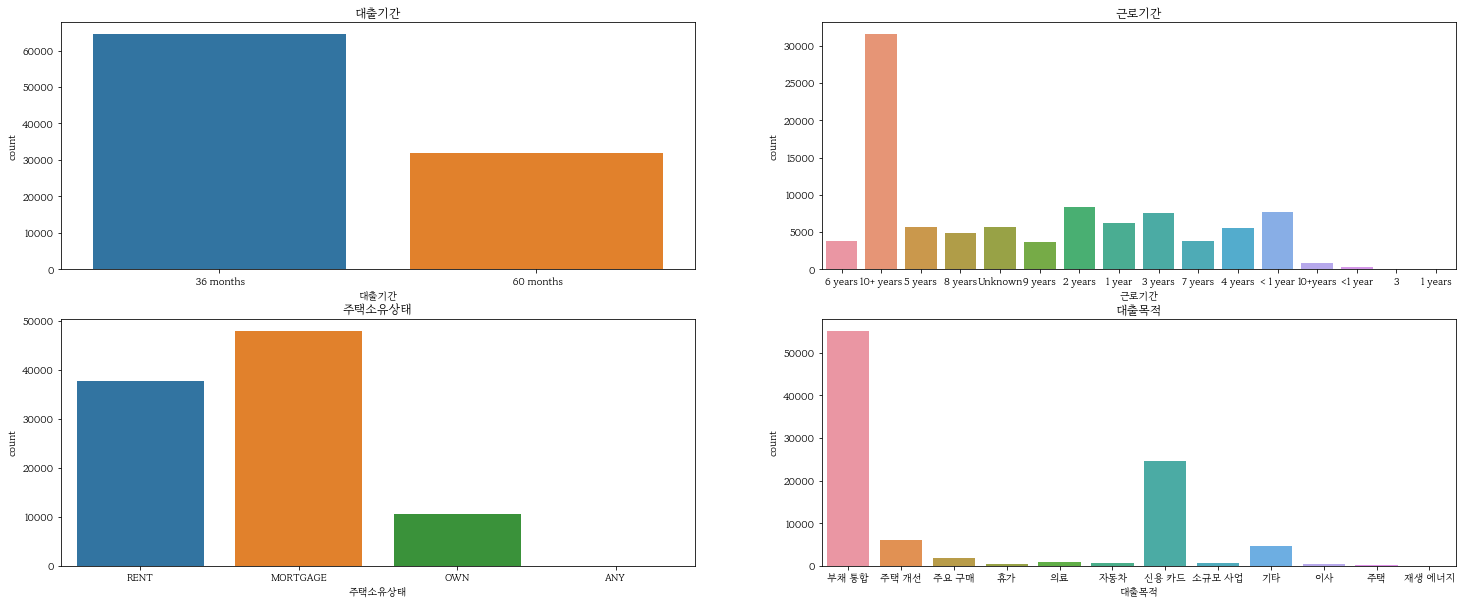

In [3]:
# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 한글 폰트 설정하기
fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='MaruBuri')

fig, axes = plt.subplots(2, 2, figsize=(25,10)) # 2x2 형식으로 4개 그래프 동시에 표시

sns.countplot(x = train_df['대출기간'], ax=axes[0][0]).set_title('대출기간')
sns.countplot(x = train_df['근로기간'], ax=axes[0][1]).set_title('근로기간')
sns.countplot(x = train_df['주택소유상태'], ax=axes[1][0]).set_title('주택소유상태')
sns.countplot(x = train_df['대출목적'], ax=axes[1][1]).set_title('대출목적')

plt.show()

## 데이터 전처리 1 : 학습 및 추론 데이터 설정
모델에게 입력할 학습 데이터와 추론 데이터를 만들어 봅시다

In [4]:
train_x = train_df.drop(columns=['ID', '근로기간', '대출등급'])
train_y = train_df['대출등급']

test_x = test_df.drop(columns=['ID', '근로기간'])

## 데이터 전처리 2 : 범주형 변수 수치화 
LabelEncoder를 통해 범주형 변수 수치화를 진행해 봅시다 

In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['대출기간', '주택소유상태', '대출목적']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i]) 
    train_x[i]=le.transform(train_x[i])
    
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_x[i]=le.transform(test_x[i])
    
display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,0,3,72000000,18.90,15,1,0,0,0.0,0.0,0.0
1,14400000,1,1,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0
2,12000000,0,1,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0


,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,0,1,132000000,19.64,12,10,0,394692,146604.0,0.0,0.0
1,8400000,0,3,89971200,15.84,25,1,0,0,0.0,0.0,0.0
2,17280000,0,3,150000000,8.41,20,3,0,1786980,281820.0,0.0,0.0


## 모델 선정 및 학습  
대출등급 분류를 위한 AI 모델을 정하고 학습시켜 봅시다  

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(train_x, train_y)

RandomForestClassifier()

## 예측 수행
.predict()를 통해 모델이 예측한 대출등급을 구해봅시다 

In [7]:
pred = model.predict(test_x)

## 제출양식에 예측결과 입력
모델이 예측한 대출등급을 제출양식에 입력해 봅시다  

In [8]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['대출등급'] = pred
sample_submission

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


## 예측결과 저장
값이 기입된 제출물을 저장해 봅시다  

In [9]:
sample_submission.to_csv('baseline_submit.csv', index=False)